# RF Design

In [1]:
import math

def convert_milli_watt_to_dbm(x):
    return 10 * math.log10(x)

def convert_dbm_to_milli_watt(x):
    return math.pow(10, x/10)

def convert_ratio_to_db(x):
    return 10 * math.log10(x)

### Definitions


- The `dBi` unit represents the gain of an antenna in decibels relative to an isotropic radiator

- The `noise figure` is a measure of how much noise is added by a device or component, such as an amplifier or a receiver, to the signal passing through it
    - Lower is better
    - NF(dB) = SNR_in(dB) - SNR_out(dB)
    - SNR_out(dB) = SNR_in(dB) - NF(dB)
    
- The `receive sensitivity` is the minimum power level of an incoming signal that the receiver can detect and correctly decode.
    - Higher is better

- The `CQI` is the Channel Quality Indicator

- The `MCS` is the Modulation and Coding Scheme

## Frequency Band

**Question:** Choose a frequency band (downlink and uplink), SISO or MIMO scheme (the so-called c and bandwidth).

**Answer:**

Assumptions from course slides:
- FFD band below 2GHz
- max 1 W transmit power
- max 20 MHz bandwidth

Use the baseline:
- 20 MHz bandwidth in the DL
- 20 MHz bandwidth in the UL
- SISO scheme
- band name n3 1800 in FR1
    - DL 1805-1880 MHz
    - UL 1710-1785 MHz
    - DL/UL 75 MHz bandwidth
    - Duplex Spacing 95 MHz

**Sources:**
- Course Slides
- https://www.sqimway.com/nr_band.php

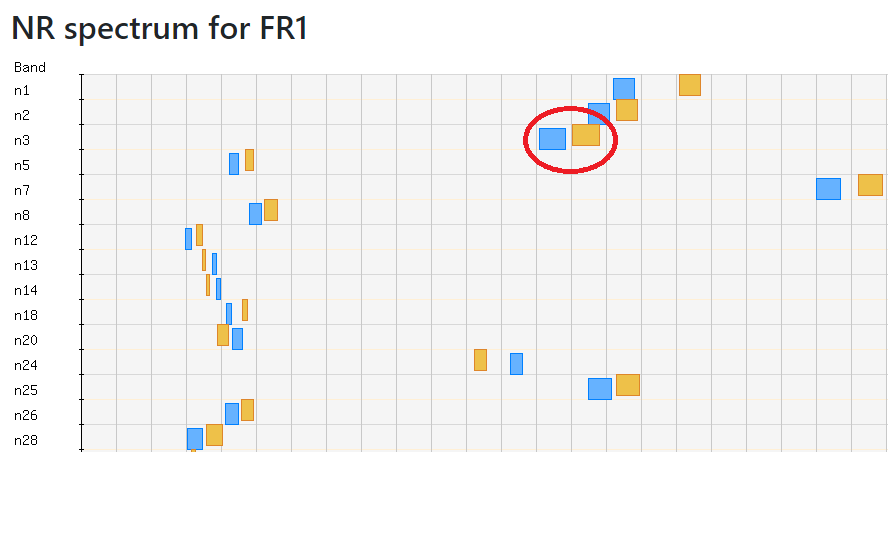

**Comment:** DL and UL bandwidths are the same in our case. There is no reason to may your life harder.

**Comment:** Is n3 already available in BE?

Useful BIPT sources:
- https://www.bipt.be/operatoren/algemene-machtigingen-voor-radiospectrumgebruik

Quoting https://www.bipt.be/consumers/5g
>
> Following the publication of the legislation, the BIPT organises a “multiband auction” in order to grant user rights in the following frequency bands: 
> - the bands for which the existing user rights for 2G and 3G expire: 900 MHz, 1800 MHz, 2100 MHz;
> - the new bands that will be used for 5G: 700 MHz, 3600 MHz, 1400 MHz.

so the n3 band is not yet available in BE.

## Antenna Choice

From Huawei Antenna Search
- https://carrier.huawei.com/en/products-wireless-network/antenna/antenna-list/passive-antenna

Choice: **Huawei A194518R0v06**
- Antenna Type: Single-band
- Frequency Range: 1710-2200 MHz
- Gain dBi 18.0
- Size 2.6m
- Horizontal 3dB beam width: 85 degrees
- Vertical 3dB beam width: 6.5 degrees

### Radiation Pattern
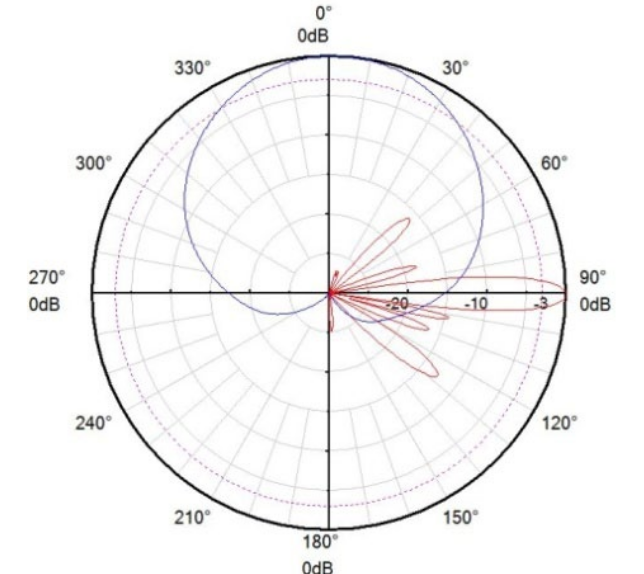

**Comment:** Interesting choice - how does this match the angles you found in the basic design?

The horizontal and vertical angles in the datasheet are all wider then the required angles for full site coverage.  
However, they are not overly wide, so they seem a good fit.

In [2]:
dl_bandwidth_hz = 20e6
dl_frequency_hz = 1842.5e6
dl_target_data_rate_bps = 15e6

ul_bandwidth_hz = 20e6
ul_frequency_hz = 1747.5e6
ul_target_data_rate_bps = 56e3

gnb_transmit_power_milli_watt = 1e3
gnb_cable_loss_db = 0.5
gnb_noise_figure_db = 5
gnb_receive_sensitivity_dbm = -102
gnb_antenna_gain_dbi = 18

ue_transmit_power_dbm = 21
ue_cable_loss_db = 0.5
ue_noise_figure_db = 9
ue_receive_sensitivity_dbm = -95
ua_antenna_gain_dbi = 0

**Comment:** Why 56kbps in UL?

I tried to find a reasonable datarate for mostly control data.  
Looking at other technologies (like GSM) a data rate between 10 and 100 kbps seemed reasonable.

In [3]:
spectral_efficiency_bps_per_hz = dl_target_data_rate_bps / dl_bandwidth_hz

print(f'spectral efficiency: {spectral_efficiency_bps_per_hz} bps/Hz')

spectral efficiency: 0.75 bps/Hz


**Comment:** this is a good approach - question: is this high or low ?

Summarizing the table from https://en.wikipedia.org/wiki/Spectral_efficiency

| Standard    | Max Spectral Efficiency bit/(s⋅Hz) |
|-------------|------------------------------------|
| Wi-Fi 6     | 7.5                                |
| Wi-Fi 5     | 5.42                               |
| LTE         | 4.08                               |
| 3G cellular | 2.5                                |

Looking at the capabilities of other technologies, we can conclude that our required spectral efficiency is low.
Meaing that we have a lot of bandwidth for a small data rate, which makes life easier.

## CQI Index

**Question:** Given these parameters, and the video requirements given higher up, calculate the theoretical CQI (MCS) index that would be required and derive the needed SNR from it.

**Answer:**
To achieve a rate of (at least) 15 Mbps on a 20 Mhz bandwidth, we need a spectral efficiency of 0.75 bps/Hz (or more).
Therefore, the minimum CQI index is 5, which uses QPSK modulation and an SINR estimate of 2.4 dB.

**Sources:**
- Course Slides Table 7.1

**Comment:** this is usually called an MCS (Modulation and Coding Scheme) index. CQI = channel quality indicator. Also, this assumes you will be able to use all resources in the downlink for your 1 UE (including all non-PDSSCH ones) - so you may want to be a bit more aggressive.

## Channel Propagation Model

**Question:** Choose a (suitable) wireless channel propagation model. Provide your rationale.

**Answer:**
We need to transmit packets from a tall building across the Schelde river to an open field with no obstructions.
Therefore, the simple `Friis` free space propagation model appears to be a suitable solution.

**Sources:**
- Course Slides Table 11.4

## Data Flow

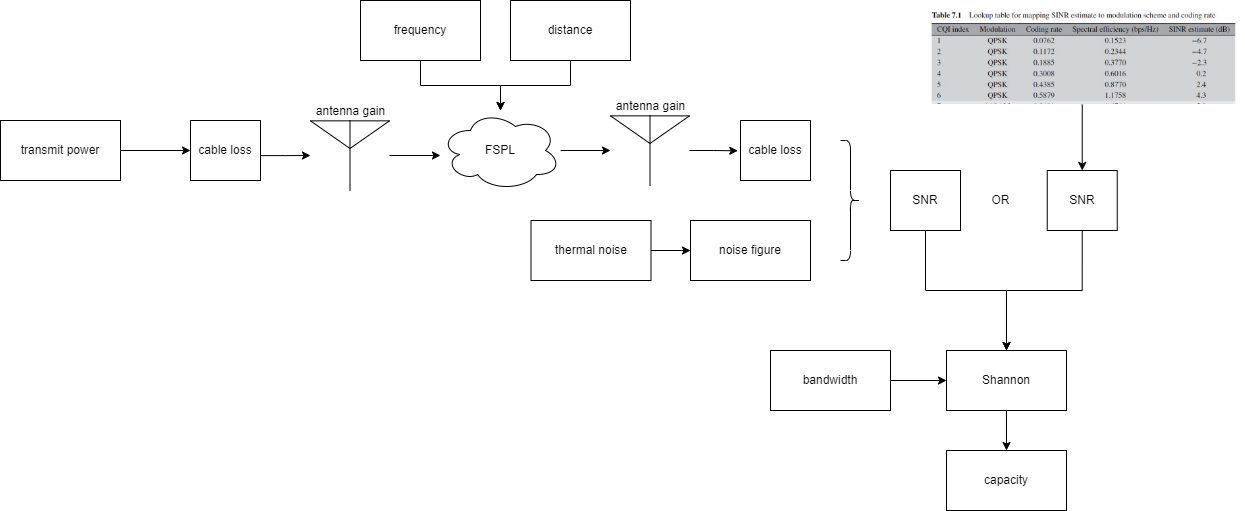

## Shannon

$$ \mathrm{SNR} = 2^{\frac{C}{B}} - 1 $$

- https://www.rfwireless-world.com/calculators/channel-capacity-calculator.html

In [4]:
def get_channel_snr(capacity_bps, bandwidth_hz):
    return math.pow(2, capacity_bps / bandwidth_hz) - 1

In [5]:
# Comment: some considerations
# This is the minimal SNR, indeed, that you need. But that is assuming no overhead and no other UEs

print('Min SNR:',math.pow(2, 15E6 / 20E6) - 1)

Min SNR: 0.681792830507429


## Thermal Noise

- https://www.everythingrf.com/rf-calculators/noise-power-calculator

In [6]:
def get_ktb_noise_dbm(bandwidth_hz, temperature_k=290):
    k = 1.38e-23  # Boltzmann constant
    return 10 * math.log10((k * bandwidth_hz * temperature_k)/1e-3)

In [7]:
get_ktb_noise_dbm(20e6)

-100.96692920035827

## Total Noise

$$ \mathrm{P_{total\_noise,dBm}} = P_\mathrm{ktb\_noise,dBm} + P_\mathrm{noise\_figure,dB} $$

## Receive Power

$$ \mathrm{SNR_{dB}} = P_\mathrm{signal,dBm} - P_\mathrm{noise,dBm} $$
$$ P_\mathrm{signal,dBm} = \mathrm{SNR_{dB}} + P_\mathrm{noise,dBm} $$

## Free Space Path Loss

- https://www.everythingrf.com/rf-calculators/free-space-path-loss-calculator

In [8]:
antenna_coordinates = [51.225779846347535, 4.400503131269632]
min_site_coordinates = [51.227090, 4.393261]
max_site_coordinates = [51.227990333375544, 4.389441701586266]

In [9]:
from geopy import distance

min_distance_m = distance.distance(antenna_coordinates, min_site_coordinates).m
max_distance_m = distance.distance(antenna_coordinates, max_site_coordinates).m

print(f'min distance: {min_distance_m:.2f} m')
print(f'max distance: {max_distance_m:.2f} m')

min distance: 526.48 m
max distance: 810.88 m


In [10]:
def get_fspl_db(distance_m, frequency_hz):
    return 20 * math.log10(distance_m) + 20 * math.log10(frequency_hz) - 147.55

In [11]:
# Comment: a quick test
get_fspl_db(500,2e9)

92.44999999999999

In [34]:
def get_distance_m_from_fspl_db(fspl_db, frequency_hz):
    x = (fspl_db - 20 * math.log10(frequency_hz) + 147.55) / 20
    return math.pow(10, x)

In [39]:
get_distance_m_from_fspl_db(92.45,2e9)

500.00000000000097

## Power Gains

In [12]:
power_gains_db = gnb_antenna_gain_dbi + ua_antenna_gain_dbi - gnb_cable_loss_db - ue_cable_loss_db

print(f'power gains: {power_gains_db:.2f} dB')

power gains: 17.00 dB


## Target Transmit Power

$$ P_\mathrm{receive,dBm} = P_\mathrm{gains,dB} - P_\mathrm{FSPL,dB} + P_\mathrm{transmit,dBm} $$
$$ P_\mathrm{transmit,dBm} = P_\mathrm{receive,dBm} - P_\mathrm{gains,dB} + P_\mathrm{FSPL,dB} $$

## gNodeB Transmit Power

In [13]:
def calculate_gnb_transmit_power():
    channel_snr = get_channel_snr(dl_target_data_rate_bps, dl_bandwidth_hz)
    channel_snr_db = convert_ratio_to_db(channel_snr)
    
    print(f'channel SNR: {channel_snr:.2f} or {channel_snr_db:.2f} dB')
    
    ktb_noise_dbm = get_ktb_noise_dbm(dl_bandwidth_hz)
    
    print(f'thermal noise: {ktb_noise_dbm:.2f} dBm')
    
    total_noise_dbm = ktb_noise_dbm + ue_noise_figure_db
    
    print(f'total noise: {total_noise_dbm:.2f} dBm')
    
    receive_power_dbm = channel_snr_db + total_noise_dbm

    print(f'receive power: {receive_power_dbm:.2f} dBm')
    
    max_fspl_db = get_fspl_db(max_distance_m, dl_frequency_hz)

    print(f'max FSPL: {max_fspl_db:.2f} dB')
    
    transmit_power_dbm = receive_power_dbm - power_gains_db + max_fspl_db
    transmit_power_milli_watt = convert_dbm_to_milli_watt(transmit_power_dbm)

    print(f'target transmit power: {transmit_power_dbm:.2f} dBm or {transmit_power_milli_watt:.2f} mW')

In [14]:
calculate_gnb_transmit_power()

channel SNR: 0.68 or -1.66 dB
thermal noise: -100.97 dBm
total noise: -91.97 dBm
receive power: -93.63 dBm
max FSPL: 95.94 dB
target transmit power: -14.69 dBm or 0.03 mW


**Conclusion:** The gNodeB transmit power is very low.

## UE Transmit Power

In [15]:
def calculate_ue_transmit_power():
    channel_snr = get_channel_snr(ul_target_data_rate_bps, ul_bandwidth_hz)
    channel_snr_db = convert_ratio_to_db(channel_snr)
    
    print(f'channel SNR: {channel_snr:.2f} or {channel_snr_db:.2f} dB')
    
    ktb_noise_dbm = get_ktb_noise_dbm(ul_bandwidth_hz)
    
    print(f'thermal noise: {ktb_noise_dbm:.2f} dBm')
    
    total_noise_dbm = ktb_noise_dbm + gnb_noise_figure_db
    
    print(f'total noise: {total_noise_dbm:.2f} dBm')
    
    receive_power_dbm = channel_snr_db + total_noise_dbm

    print(f'receive power: {receive_power_dbm:.2f} dBm')
    
    max_fspl_db = get_fspl_db(max_distance_m, ul_frequency_hz)

    print(f'max FSPL: {max_fspl_db:.2f} dB')
    
    transmit_power_dbm = receive_power_dbm - power_gains_db + max_fspl_db
    transmit_power_milli_watt = convert_dbm_to_milli_watt(transmit_power_dbm)

    print(f'target transmit power: {transmit_power_dbm:.2f} dBm or {transmit_power_milli_watt:.2f} mW')

In [16]:
calculate_ue_transmit_power()

channel SNR: 0.00 or -27.12 dB
thermal noise: -100.97 dBm
total noise: -95.97 dBm
receive power: -123.08 dBm
max FSPL: 95.48 dB
target transmit power: -44.61 dBm or 0.00 mW


**Conclusion:** The UE transmit power is negligible.

## Max Distance for 1W of gNodeB Transmit Power

In [42]:
def calculate_max_distance_given_gnb_transmit_power(transmit_power_milli_watt):
    channel_snr = get_channel_snr(dl_target_data_rate_bps, ul_bandwidth_hz)
    channel_snr_db = convert_ratio_to_db(channel_snr)

    print(f'channel SNR: {channel_snr:.2f} or {channel_snr_db:.2f} dB')

    ktb_noise_dbm = get_ktb_noise_dbm(dl_bandwidth_hz)

    print(f'thermal noise: {ktb_noise_dbm:.2f} dBm')

    total_noise_dbm = ktb_noise_dbm + ue_noise_figure_db
    
    print(f'total noise: {total_noise_dbm:.2f} dBm')

    receive_power_dbm = channel_snr_db + total_noise_dbm

    print(f'receive power: {receive_power_dbm:.2f} dBm')

    if ue_receive_sensitivity_dbm < receive_power_dbm:
        print('INFO: We are NOT limited by the receive sensitivity')
    else:
        print('WARNING: We are limited by the receive sensitivity')
        receive_power_dbm = ue_receive_sensitivity_dbm
        print(f'new receive power: {receive_power_dbm:.2f} dBm')

    transmit_power_dbm = convert_milli_watt_to_dbm(transmit_power_milli_watt)
    
    print(f'transmit power: {transmit_power_milli_watt:.2f} mW or {transmit_power_dbm:.2f} dBm')

    # P_receive_dBm = P_gains_dB - P_FSPL_dB + P_transmit_dBm
    # P_FSPL_dB = P_gains_dB + P_transmit_dBm - P_receive_dBm
    fspl_db = power_gains_db + transmit_power_dbm - receive_power_dbm
    
    print(f'FSPL: {fspl_db:.2f} dB')

    distance_m = get_distance_m_from_fspl_db(fspl_db, dl_frequency_hz)

    print(f'distance: {distance_m:.2f} m or {distance_m/1000:.2f} km')
    

In [43]:
calculate_max_distance_given_gnb_transmit_power(1000)

channel SNR: 0.68 or -1.66 dB
thermal noise: -100.97 dBm
total noise: -91.97 dBm
receive power: -93.63 dBm
INFO: We are NOT limited by the receive sensitivity
transmit power: 1000.00 mW or 30.00 dBm
FSPL: 140.63 dB
distance: 139191.51 m or 139.19 km


**Conclusion**: In real deployments, we will never get a range of 140 km, to perform a more representative analysis, we should use a different propagation loss model than free space.